# Demo 3: Running serial simulations with OpenMM
In the penultimate example of this series, we show how easy managing, running, and chaining together OpenMM simulations can be with `polymerist`

In [1]:
import warnings 
warnings.catch_warnings(record=True)

import logging
logging.basicConfig(level=logging.INFO)

In [2]:
from pathlib import Path
from polymerist.genutils.fileutils.pathutils import is_empty, assemble_path


EXAMPLE_DIR = Path('prepared_system_examples')
assert EXAMPLE_DIR.exists() and not is_empty(EXAMPLE_DIR)

OUTPUT_DIR = Path('scratch_MD') # dummy directory for writing without tampering with example inputs
OUTPUT_DIR.mkdir(exist_ok=True)

## Loading a prepared polymer topology
Check out the [previous demo all about this](3.1-MD_export_with_Interchange.ipynb) this if you haven't already

In [3]:
from openff.toolkit import ForceField
from openff.interchange import Interchange

warnings.filterwarnings('ignore', category=DeprecationWarning) # catches annoying DeprecationWarnings from Interchange
logging.getLogger('openff.interchange.smirnoff._nonbonded').setLevel(logging.CRITICAL) # suppress spammy "Preset charges..." logs otherwise printed for EVERY atom in an Interchange

from polymerist.mdtools.openfftools.topology import topology_from_sdf
from polymerist.mdtools.openfftools.boxvectors import get_topology_bbox


prepared_polymer_system_sdf = assemble_path(EXAMPLE_DIR, 'PNIPAAm_solv_water_TIP3P', 'sdf')
assert prepared_polymer_system_sdf.exists()
polymer_topology = topology_from_sdf(prepared_polymer_system_sdf)

forcefield = ForceField('openff-2.1.0.offxml') # choose a different forcefield here if you wish
interchange = Interchange.from_smirnoff(forcefield, polymer_topology, charge_from_molecules=list(polymer_topology.unique_molecules))
interchange.box = get_topology_bbox(polymer_topology)
interchange.visualize()

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/smirnoff99frosst/smirnoff99frosst.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:openff.toolkit.typing.engines.smirnoff.parameters:Attempting to up-convert vdW section from 0.3 to 0.4
INFO:openff.toolkit.typing.engines.smirnoff.parameters:Successfully up-converted vdW section from 0.3 to 0.4. `method="cutoff"` is now split into `periodic_method="cutoff"` and `nonperiodic_method="no-cutoff"`.
INFO:openff.toolkit.typing.engines.smirnoff.parameters

NGLWidget()

## Defining simulation parameters
Also check out the dedicated demo on [defining simulation parameters](3.2-defining_simulation_parameters.ipynb) if you haven't already!

### Equilbration parameters:
Here we demonstrate an initial NPT equilibration simulation, with parameter sets defined via the API

In [4]:
from openmm.unit import femtosecond, picosecond, nanosecond, kelvin, atmosphere
from polymerist.mdtools.openmmtools.parameters import (
    ThermoParameters,
    ThermostatParameters,
    BarostatParameters,
    IntegratorParameters,
    ReporterParameters,
    SimulationParameters
)

equilibration_params = SimulationParameters(
    thermo_params=ThermoParameters(
        thermostat_params=ThermostatParameters(
            temperature=300*kelvin,
            timescale=1/picosecond,
            thermostat='LangevinMiddle'
        ),
        barostat_params=BarostatParameters(
            pressure=1*atmosphere,
            barostat='MC', # Monte-Carlo barostat
        )
    ),
    integ_params=IntegratorParameters(
        time_step=2*femtosecond,
        total_time=10*picosecond,
        num_samples=50,
    ),
    reporter_params=ReporterParameters(
        report_state=True,
        report_checkpoint=True,
        report_state_data=True,
    ),
)

print(equilibration_params.thermo_params.describe_ensemble())

NPT (Isothermal-isobaric) ensemble


### Production parameters:
Following equilibration, we'd like to run an NVT (i.e. thermostatted, but not barostatted) production simulation  
These can also be defined via the API, but here we load them from a file just to show you that you can also fetch your simulation parameters that way

In [5]:
prod_params_path = assemble_path(EXAMPLE_DIR, 'prod_params', 'json')
assert prod_params_path.exists()

production_params = SimulationParameters.from_file(prod_params_path)
print(production_params.thermo_params.describe_ensemble())

NVT (Canonical) ensemble


Note that this "production" is relatively short just so this demo doesn't take forever, but you can image making this as long as you need

In [6]:
print(production_params.integ_params.total_time)

20 ps


## Running a simulation "schedule"
A "schedule" here denotes a serial sequence of simulations, each defined by their own SimulationParameters, each run in its own dedicated directory  
The initial topology, system, and positions provided will be passed to the first simulation in the schedule; all subsequent simulations will obtain these from the end of the previous simulation

<font color='red'>STATE IS NOT SHARED BETWEEN SUCCESSIVE SIMULATIONS IN A SCHEDULE</font>; At least as of this release, each simulation generate a new, empty State  
to avoid back-to-back simulations with potentially vastly-different thermodynamic parameters from contaminating one another

In [7]:
from polymerist.genutils.logutils.IOHandlers import MSFHandlerFlex 
from polymerist.mdtools.openmmtools.execution import run_simulation_schedule


polymer_name : str = prepared_polymer_system_sdf.stem
POLYMER_SIM_DIR = OUTPUT_DIR / polymer_name
POLYMER_SIM_DIR.mkdir(exist_ok=True)

logpath = assemble_path(POLYMER_SIM_DIR, 'simulation_status', 'log')
with MSFHandlerFlex(filename=logpath, proc_name=f'{polymer_name}_sims') as logger:
    history = run_simulation_schedule(
        POLYMER_SIM_DIR, 
        schedule={ # simulations will be run in the order they appear here
            'equilibration' : equilibration_params, 
            'production'    : production_params,
        }, 
        init_top=interchange.to_openmm_topology(),
        init_sys=interchange.to_openmm(combine_nonbonded_forces=False),
        init_pos=interchange.get_positions(include_virtual_sites=True).to_openmm(),
        return_history=True
    )

INFO:polymerist.mdtools.openmmtools.execution:Initializing simulation 1/2 ("equilibration")
INFO:polymerist.mdtools.openmmtools.thermo:Created MonteCarloBarostat Force for NPT (Isothermal-isobaric) ensemble
INFO:polymerist.mdtools.openmmtools.preparation:Registering new Force "MonteCarloBarostat" to System to enforce chosen ensemble (isothermal-isobaric)
INFO:polymerist.mdtools.openmmtools.thermo:Created LangevinMiddleIntegrator for NPT (Isothermal-isobaric) ensemble
INFO:polymerist.mdtools.openmmtools.preparation:Setting positions in Context
INFO:polymerist.mdtools.openmmtools.reporters:Prepared DCDReporter which reports to scratch_MD/PNIPAAm_solv_water_TIP3P/equilibration/equilibration_trajectory.dcd
INFO:polymerist.mdtools.openmmtools.reporters:Prepared CheckpointReporter which reports to scratch_MD/PNIPAAm_solv_water_TIP3P/equilibration/equilibration_checkpoint.chk
INFO:polymerist.mdtools.openmmtools.reporters:Prepared StateReporter which reports to scratch_MD/PNIPAAm_solv_water_TI

## Inspecting simulation history
You may notice that `run_simulation_schedule(...)` returns a "history" in the above cell; this output enables you to access and inspect the final state of each simulation that was run  
The "history" is a dict whose keys are the names you've assigned to each simulation step and whose values are a dict containing the completed Simulation (in its final state) and associate paths

In [8]:
history

{'equilibration': {'simulation': <openmm.app.simulation.Simulation at 0x7f123d4d52d0>,
  'paths': SimulationPaths(parameters_path=PosixPath('scratch_MD/PNIPAAm_solv_water_TIP3P/equilibration/equilibration_parameters.json'), paths_path=PosixPath('scratch_MD/PNIPAAm_solv_water_TIP3P/equilibration/equilibration_paths.json'), system_path=PosixPath('scratch_MD/PNIPAAm_solv_water_TIP3P/equilibration/equilibration_system.xml'), topology_path=PosixPath('scratch_MD/PNIPAAm_solv_water_TIP3P/equilibration/equilibration_topology.pdb'), state_path=PosixPath('scratch_MD/PNIPAAm_solv_water_TIP3P/equilibration/equilibration_state.xml'), checkpoint_path=PosixPath('scratch_MD/PNIPAAm_solv_water_TIP3P/equilibration/equilibration_checkpoint.chk'), trajectory_path=PosixPath('scratch_MD/PNIPAAm_solv_water_TIP3P/equilibration/equilibration_trajectory.dcd'), state_data_path=PosixPath('scratch_MD/PNIPAAm_solv_water_TIP3P/equilibration/equilibration_state_data.csv'), time_data_path=None, spatial_data_path=None)

### Use case 1: assessing equilibration
For example, we could pull out the paths from our equilibration simulation and look at the simulation state data to assess whether our system has really equilibrated

In [9]:
equil_paths = history['equilibration']['paths']
print(type(equil_paths))
print(equil_paths.parameters_path)

<class 'polymerist.mdtools.openmmtools.serialization.paths.SimulationPaths'>
scratch_MD/PNIPAAm_solv_water_TIP3P/equilibration/equilibration_parameters.json


In [10]:
import pandas as pd
import matplotlib.pyplot as plt


state_data = pd.read_csv(equil_paths.state_data_path)
state_data.head(10)

,"#""Step""",Time (ps),Potential Energy (kJ/mole),Kinetic Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K),Box Volume (nm^3),Density (g/mL),Speed (ns/day)
0,100,0.2,-100624.727248,3011.681152,-97613.046096,55.945939,50.975363,1.244546,0
1,200,0.4,-98430.672130,5380.300781,-93050.371349,99.946165,51.350989,1.235443,167
2,300,0.6,-96566.835628,7422.079102,-89144.756527,137.874883,51.643101,1.228455,134
3,400,0.8,-95014.648069,8945.779297,-86068.868772,166.179619,52.096960,1.217753,128
4,500,1.0,-93616.355863,10140.125977,-83476.229886,188.366180,52.579272,1.206582,132
5,600,1.2,-92518.071114,11113.230469,-81404.840645,206.442876,53.177082,1.193018,130
6,700,1.4,-91498.945511,11905.093750,-79593.851761,221.152778,53.857463,1.177946,132
7,800,1.6,-90669.505316,12634.230469,-78035.274847,234.697452,54.598851,1.161951,129
8,900,1.8,-89857.910875,13115.387695,-76742.523180,243.635580,54.869692,1.156216,131
9,1000,2.0,-89050.618708,13204.975586,-75845.643122,245.299793,56.195878,1.128930,133


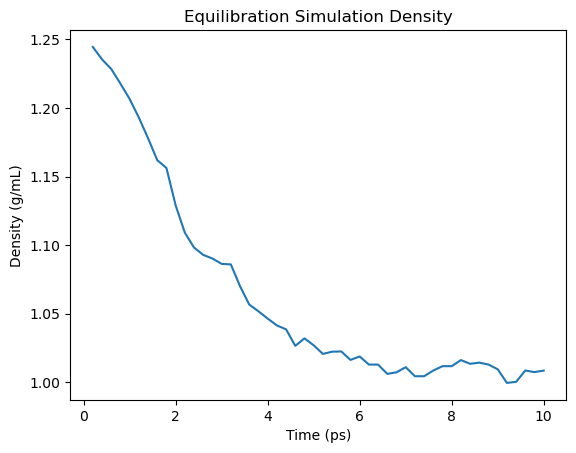

In [11]:
x_prop : str = 'Time (ps)'
y_prop : str = 'Density (g/mL)'

plt.plot(state_data[x_prop], state_data[y_prop])
plt.xlabel(x_prop)
plt.ylabel(y_prop)
plt.title('Equilibration Simulation Density')
plt.show()

### Use case 2: analyzing potential energy contributions
As another useful example, we can perform a single-point energy evaluation of the final state of our simulation, or inspect the forces acting upon it

In [12]:
prod_sim = history['production']['simulation']
print(type(prod_sim))
print(prod_sim.context.getState(getEnergy=True).getPotentialEnergy())

<class 'openmm.app.simulation.Simulation'>
-85220.10980971856 kJ/mol


In [13]:
from polymerist.mdtools.openmmtools.evaluation import get_openmm_energies_separated

get_openmm_energies_separated(prod_sim.context)

{'Total potential energy': -85220.10980971856 kJ/mol,
 'Total kinetic energy': 15866.88671875 kJ/mol,
 'vdW force potential energy': 16201.69438646046 kJ/mol,
 'Electrostatics force potential energy': -99098.69641572249 kJ/mol,
 'vdW 1-4 force potential energy': 489.31726837158203 kJ/mol,
 'Electrostatics 1-4 force potential energy': -5497.47802734375 kJ/mol,
 'PeriodicTorsionForce potential energy': 1059.057867050171 kJ/mol,
 'HarmonicAngleForce potential energy': 1300.409423828125 kJ/mol,
 'HarmonicBondForce potential energy': 325.5997009277344 kJ/mol,
 'CMMotionRemover potential energy': 0.0 kJ/mol,
 'AndersenThermostat potential energy': 0.0 kJ/mol}

In [14]:
from polymerist.mdtools.openmmtools.forces import describe_forces

describe_forces(prod_sim.system)

{'vdW force': {'CutoffDistance': 0.9 nm,
  'EnergyFunction': '4*epsilon*((sigma/r)^12-(sigma/r)^6); sigma=(sigma1+sigma2)/2; epsilon=sqrt(epsilon1*epsilon2); ',
  'ForceGroup': 0,
  'Name': 'vdW force',
  'NonbondedMethod': 2,
  'NumComputedValues': 0,
  'NumEnergyParameterDerivatives': 0,
  'NumExclusions': 8734,
  'NumFunctions': 0,
  'NumGlobalParameters': 0,
  'NumInteractionGroups': 0,
  'NumParticles': 6368,
  'NumPerParticleParameters': 2,
  'NumTabulatedFunctions': 0,
  'SwitchingDistance': 0.8 nm,
  'UseLongRangeCorrection': True,
  'UseSwitchingFunction': True,
  'Type': 'CustomNonbondedForce',
  'LongRangeNonbondedMethod': 'CutoffPeriodic'},
 'Electrostatics force': {'CutoffDistance': 0.9 nm,
  'EwaldErrorTolerance': 0.0001,
  'ExceptionsUsePeriodicBoundaryConditions': False,
  'ForceGroup': 1,
  'IncludeDirectSpace': True,
  'LJPMEParameters': [0.0, 0, 0, 0],
  'Name': 'Electrostatics force',
  'NonbondedMethod': 4,
  'NumExceptionParameterOffsets': 0,
  'NumExceptions': 87